In [2]:
import os
import h5py
from h5py import Dataset, Group, File
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.vgg import VGG
import torch.optim as optim
from torch.optim import lr_scheduler

## Data Processing

Here we read the data from the .h5 file.

In [5]:
with h5py.File('./data/lab2_train_data.h5',"r") as f:
    for key in f.keys():
        print(f[key], key, f[key].name)
with h5py.File('./data/lab2_test_data.h5',"r") as f:
    for key in f.keys():
        print(f[key], key, f[key].name)

<HDF5 dataset "color_codes": shape (34, 3), type "<i8"> color_codes /color_codes
<HDF5 dataset "rgb": shape (2975, 128, 256, 3), type "|u1"> rgb /rgb
<HDF5 dataset "seg": shape (2975, 128, 256, 1), type "|u1"> seg /seg
<HDF5 dataset "color_codes": shape (34, 3), type "<i8"> color_codes /color_codes
<HDF5 dataset "rgb": shape (500, 128, 256, 3), type "|u1"> rgb /rgb
<HDF5 dataset "seg": shape (500, 128, 256, 1), type "|u1"> seg /seg


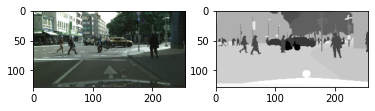

In [6]:
with File('./data/lab2_train_data.h5','r') as f:
    TrainImages=f['rgb'][()]
    TrainSeg=f['seg'][()].squeeze()
    Color_codes=f['color_codes'][()]
with File('./data/lab2_test_data.h5','r') as f:
    TestImages=f['rgb'][()]
    TestSeg=f['seg'][()].squeeze()

plt.subplot(1,2,1)
plt.imshow(TrainImages[456])
plt.subplot(1,2,2)
plt.imshow(TrainSeg[456].squeeze(),cmap='binary')
plt.show()

Here is a example.

The ids in *seg* correspond to the original id in CityScapes. We need to transform them into *trainId*, following the recommendations of the data provider. (Click [here](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) for further information)

In [ ]:
ID2TrainID = {}
Label = namedtuple('Label', [
                   'name', 
                   'id', 
                   'trainId', 
                   'category', 
                   'categoryId', 
                   'hasInstances', 
                   'ignoreInEval', 
                   'color'])
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,       9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# change ID to TrainID
for obj in labels:
    TrainID   = obj.trainId
    idx = obj.id
    if obj.ignoreInEval:
            ID2TrainID[idx]=19
    else:
        ID2TrainID[idx] = TrainID

#print(ID2TrainID)

#train data
n,h,w=TrainSeg.shape
TrainLabels=np.zeros((n,h,w))
for i in tqdm(range(n)):
    for j in range(h):
        for k in range(w):
            TrainLabels[i][j][k]=ID2TrainID[TrainSeg[i][j][k]]
#test data
n,h,w=TestSeg.shape
TestLabels=np.zeros((n,h,w))
for i in tqdm(range(n)):
    for j in range(h):
        for k in range(w):
            TestLabels[i][j][k]=ID2TrainID[TestSeg[i][j][k]]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.76it/s]


**TrainLabels** and **TestLabels** store the **TrainID** of the images. Here we can see whether they are valid and the **distribution of TrainID**.

In [ ]:
TrainLabels=TrainLabels.astype(np.uint8)
TestLabels=TestLabels.astype(np.uint8)

Labelset=set()
l=[]
print('TrainLabels:',TrainLabels.shape)
n,h,w=TrainLabels.shape
for i in tqdm(range(n)):
    for j in range(h):
        for k in range(w):
            Labelset.add(TrainLabels[i][j][k])
            l.append(TrainLabels[i][j][k])
print(Labelset)

Labelset=set()
print('TestLabels:',TestLabels.shape)
n,h,w=TestLabels.shape
for i in tqdm(range(n)):
    for j in range(h):
        for k in range(w):
            Labelset.add(TestLabels[i][j][k])
            l.append(TestLabels[i][j][k])
print(Labelset)

TrainLabels: (2975, 128, 256)


100%|██████████████████████████████████████████████████████████████████████████████| 2975/2975 [02:20<00:00, 21.12it/s]


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
TestLabels: (500, 128, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.27it/s]


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


*TrainLabels* and *TestLabels* both contain all different *TrainID*.

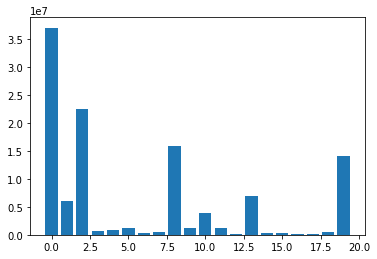

In [ ]:
dis=Counter(l)
plt.bar([i for i in range(20)],[dis[i] for i in range(20)])
plt.show()

The distribution of *TrainID* is a little imbalanced.

The modified data is saved.

In [ ]:
np.save('./data/TrainLabels.npy',TrainLabels)
np.save('./data/TestLabels.npy',TestLabels)
print('Modified data has been saved.')

Modified data has been saved.


## Data Loading

In [7]:
TrainLabels=np.load('./data/TrainLabels.npy')
TestLabels=np.load('./data/TestLabels.npy')

Define a new class *CityScapesDataset*.

In *CityScapesDataset*, images are **normalized**.

In [8]:
class CityScapesDataset(Dataset):

    def __init__(self, images,labels, n_class=20):
        self.n_class = n_class
        
        # Normalize
        img = np.transpose(images, (0, 3, 1, 2)) / 255.   #(n,3,128,256)
        img[:,0] -= 0.485
        img[:,1] -= 0.456
        img[:,2] -= 0.406
        img[:,0]/=0.229
        img[:,1]/=0.224
        img[:,2]/=0.225
        # convert to tensor
        img = torch.tensor(img,dtype=torch.float)
        label = torch.tensor(labels,dtype=torch.int)
        
        self.images=img
        self.labels=label

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        n, h, w = self.labels.shape
        target = torch.zeros((20, h, w),dtype=torch.int)
        for c in range(20):
            target[c][self.labels[idx] == c] = 1
        
        sample = {'X': self.images[idx], 'Y': target, 'l': self.labels[idx]}
        return sample
    
TrainData=CityScapesDataset(TrainImages,TrainLabels)
TestData=CityScapesDataset(TestImages,TestLabels)

## Model

*FCN32s*, *FCN16s*, *FCN8s* and *VGGNet* are defined. The encoder in *FCN* is based on *VGG*.

In [9]:
class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [10]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output
    
    
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

Here we test if the models are correctly defined.

In [35]:
vgg_model = VGGNet(requires_grad=True)
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=20)
fcn_model

FCN8s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
  

## Training

For simplicity, we are not going to train *FCN32s*, *FCN16s* and *FCN8s* sequentially, but train *FCN8s* directly.

In [37]:
use_gpu = torch.cuda.is_available()
model_dir = './saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

n_class    = 20
batch_size = 6
epochs     = 100
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
h=128
w=256

if use_gpu:
    vgg_model.cuda()
    fcn_model.cuda()
trainloader=DataLoader(TrainData,shuffle=True,batch_size=batch_size)
testloader=DataLoader(TestData,shuffle=False,batch_size=batch_size)

Criterion and Optimizer

In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs

The function of train and test

In [39]:
loss_list=[]
miou_list=[]
acc_list=[]
def train():
    for epoch in range(epochs):
        fcn_model.train()
        train_loss=0
        #ts = time.time()
        for iter, batch in enumerate(trainloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = batch['X'].cuda()
                labels = batch['Y'].cuda()
            else:
                inputs, labels = batch['X'], batch['Y']

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        
        #print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        print("epoch{}, loss{}".format(epoch+1, train_loss/len(trainloader)))
        loss_list.append(train_loss/len(trainloader))
        val(epoch)
        scheduler.step()
    torch.save(fcn_model, os.path.join(model_dir,'model.pth'))


def val(epoch):
    with torch.no_grad():
        evaluator=Evaluator(n_class)
        fcn_model.eval()
        total_ious = []
        pixel_accs = []
        for iter, batch in enumerate(testloader):
            if use_gpu:
                inputs = batch['X'].cuda()
            else:
                inputs = batch['X']

            output = fcn_model(inputs)
            output = output.data.cpu().numpy()

            N, _, h, w = output.shape
            pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)
            target = batch['l'].cpu().numpy().reshape(N, h, w)
            evaluator.add_batch(target,pred)
        acc=evaluator.Pixel_Accuracy()
        miou=evaluator.Mean_Intersection_over_Union()
        acc_list.append(acc)
        miou_list.append(miou)
        print("epoch{}, pix_acc: {}, meanIoU: {}".format(epoch+1, acc, miou))

The ways of evaluating the model are defined.

In [40]:
class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

In [41]:
train()

epoch1, loss0.602580142718169
epoch1, pix_acc: 0.8054966430664062, meanIoU: 0.23334011473071894
epoch2, loss0.4766724944234856
epoch2, pix_acc: 0.8215399169921875, meanIoU: 0.2543513274110777
epoch3, loss0.34038312594977116
epoch3, pix_acc: 0.8357979125976562, meanIoU: 0.26360748386558525
epoch4, loss0.21965346124864393
epoch4, pix_acc: 0.8324521484375, meanIoU: 0.26132225746840987
epoch5, loss0.13275402958594984
epoch5, pix_acc: 0.8420523071289062, meanIoU: 0.27510139357790664
epoch6, loss0.08085475729087428
epoch6, pix_acc: 0.843527587890625, meanIoU: 0.29162018133199474
epoch7, loss0.05407055541722765
epoch7, pix_acc: 0.8361978149414062, meanIoU: 0.2902602972218958
epoch8, loss0.0418706277926122
epoch8, pix_acc: 0.8507548828125, meanIoU: 0.2992096529155498
epoch9, loss0.03564592199249854
epoch9, pix_acc: 0.8493770751953125, meanIoU: 0.30125552834938285
epoch10, loss0.03264136172665824
epoch10, pix_acc: 0.8518975830078125, meanIoU: 0.3212982734911824
epoch11, loss0.03059102440508263


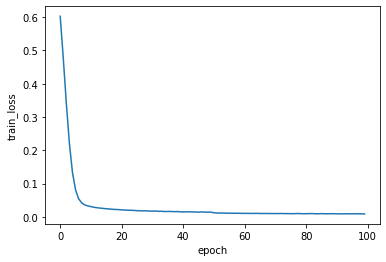

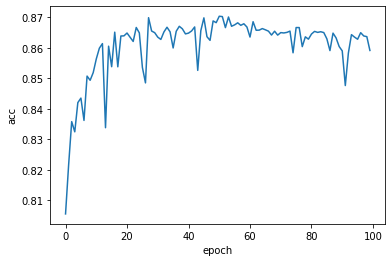

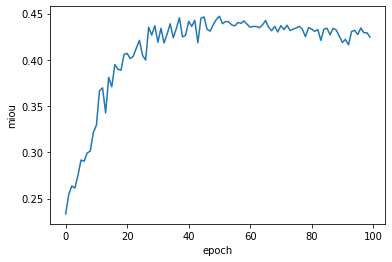

In [43]:
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot([i for i in range(100)],loss_list)
plt.show()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot([i for i in range(100)],acc_list)
plt.show()
plt.xlabel('epoch')
plt.ylabel('miou')
plt.plot([i for i in range(100)],miou_list)
plt.show()

The miou reaches a maximum of around 0.45, which is lower than the report from the leaderboard of CityScapes. 

## Problems and Future Studies

* Due to the limitation of computing power, we only train 100 epochs with few experiments on hyper-parameters. They all follow the settings of the github repo [pochih
/
FCN-pytorch](https://github.com/pochih/FCN-pytorch). More training and adjustments to hyper-parameters may lead to better results.

* Due to lack of knowledge, we are unable to conduct the studies on **uncertainty**. We will study further on this aspect.

* The lower *miou* may come from the size of the data we get, which is 128 \* 256, much smaller than the standard 2048 \* 4096. In addition, data augmentation is not used in the experiment, which may improve the results. 